## Palmer Penguin Predictions

### Imports

In [382]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

# import numpy as np
# import pandas as pd
# import seaborn as sns 
import matplotlib.pyplot as plt

from palmerpenguins import load_penguins

In [383]:
penguins = load_penguins()
penguins.dropna(inplace=True)
penguins.drop(columns='year', inplace=True)
X = penguins.drop(columns='sex')
y = penguins['sex']

### Preprocess data

In [384]:
le = LabelEncoder()
y = le.fit_transform(y)

In [385]:
preproc = make_column_transformer(
			(StandardScaler(), make_column_selector(dtype_exclude='object')),
			(OneHotEncoder(handle_unknown='ignore', sparse=False), 
				    make_column_selector(dtype_include='object'))
		    )

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4)

preproc.fit(X_train)
X_preproc = preproc.transform(X)
X_train_preproc = preproc.transform(X_train)
X_test_preproc = preproc.transform(X_test)
X_test_preproc.shape

(200, 10)

### Baseline Score

In [434]:
base_model = SGDClassifier(max_iter=1000, loss='log_loss')

cv_log = cross_validate(base_model, X_preproc, y, scoring=['accuracy'], cv=10)
log_mod = base_model.fit(X_preproc, y)
log_score = log_mod.score(X_preproc, y)
print(f"accuracy: {cv_log['test_accuracy'].mean()}, log loss: {log_score}")

accuracy: 0.8978609625668449, log loss: 0.8858858858858859


### Deep Learning Model

In [435]:
def init_mod(model, opt):
    
    model.add(layers.Dense(2, activation='relu', input_dim=10))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [436]:
def fit_mod(model, n_epochs=50):
    
    es = callbacks.EarlyStopping(patience=3)

    history = model.fit(X_train_preproc, y_train, 
                        batch_size=3, epochs=n_epochs,
                        validation_split=0.3,
                        callbacks=[es], verbose=0)
    
    return history

In [437]:
model = Sequential()

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

model = init_mod(model, opt)

history = fit_mod(model, n_epochs=150)

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           (None, 2)                 22        
                                                                 
 dense_167 (Dense)           (None, 1)                 3         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
None


### Evaluate

In [438]:
model.evaluate(X_test_preproc, y_test)

7/7 [==============================] - 0s 1ms/step - loss: 0.2490 - accuracy: 0.8900


[0.24901197850704193, 0.8899999856948853]

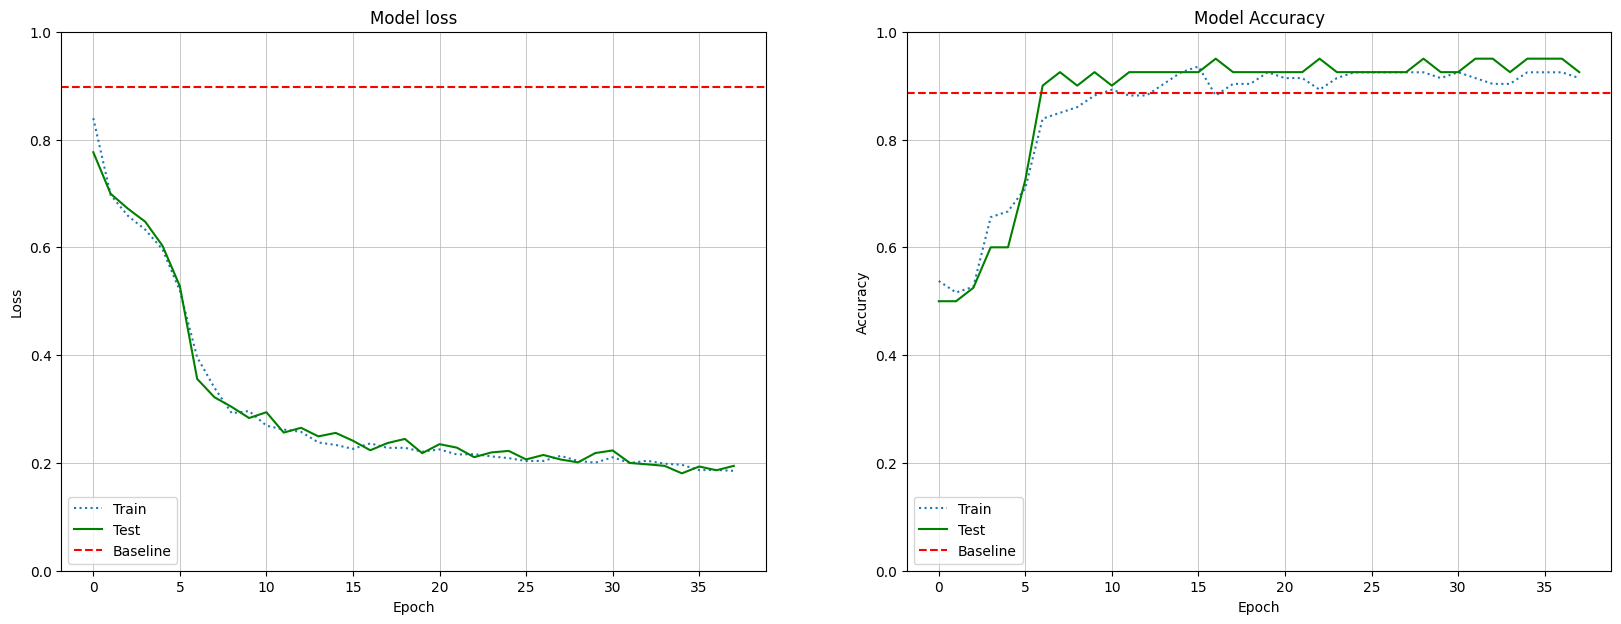

In [439]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'], linestyle=':')
    ax[0].plot(history.history['val_loss'], color='green')
    ax[0].axhline(y=cv_log['test_accuracy'].mean(), color='red', linestyle='--')
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,1))
    ax[0].legend(['Train', 'Test', 'Baseline'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'], linestyle=':')
    ax[1].plot(history.history['val_accuracy'], color='green')
    ax[1].axhline(y=log_score, color='red', linestyle='--')
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test', 'Baseline'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

plot_loss_accuracy(history)
plt.show();